In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE

In [2]:
data_path = "/workspaces/deteccion_clientes_banco/data/bank-additional-full.csv"
df = pd.read_csv(data_path, sep=";")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [3]:
df["y"].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

## Encoding

In [4]:
df.value_counts()

age  job          marital  education            default  housing  loan  contact    month  day_of_week  duration  campaign  pdays  previous  poutcome     emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
36   retired      married  unknown              no       no       no    telephone  jul    thu          88        1         999    0         nonexistent   1.4          93.918          -42.7          4.966      5228.1       no     2
39   blue-collar  married  basic.6y             no       no       no    telephone  may    thu          124       1         999    0         nonexistent   1.1          93.994          -36.4          4.855      5191.0       no     2
27   technician   single   professional.course  no       no       no    cellular   jul    mon          331       2         999    0         nonexistent   1.4          93.918          -42.7          4.962      5228.1       no     2
55   services     married  high.school          unknown  no       no    cellular 

In [5]:
def encoding(df):
    encode = df 
    encode.drop(columns=['default',"poutcome"], inplace=True) # Eliminamos las columnas que no se utilizarán en el encoding

    """## target"""
    encode['y'] = encode['y'].astype(str)
    encode['y'] = encode['y'].map({'no': 0, 'yes': 1})

    """## occupation"""
    categorical_cols = encode.select_dtypes(include=['object']).columns
    cardinality = {}

    # Convertir las columnas categóricas a tipo 'category' para optimizar memoria
    for col in categorical_cols:
        cardinality[col] = encode[col].nunique()

    """### previous"""
    #Binning de previous
    encode['previous_bin'] = pd.cut(df['previous'], bins=[-1, 0, 2, np.inf], labels=[0, 1, 2])
    encode["previous_bin"] = encode["previous_bin"].astype(int)
    encode["previous_bin"].value_counts()
    # 0: Nada (0 contactos), 1: Poco (1 o 2 contactos), 2: Mucho (3-7)

    """### Job"""
    job_target_mean = encode.groupby('job')['y'].mean()
    encode['job_target_mean'] = encode['job'].map(job_target_mean)
    encode.drop('job', axis=1, inplace=True)

    """### Marital"""
    marital_dummies = pd.get_dummies(encode['marital'], prefix='marital', dtype=int)
    encode = pd.concat([encode, marital_dummies], axis=1)
    encode.drop('marital', axis=1, inplace=True)

    """### Education"""
    education_counts = encode['education'].value_counts(normalize=True)
    encode['education_freq_encode'] = encode['education'].map(education_counts)
    encode.drop('education', axis=1, inplace=True)

    """### Housing, Loan y Contact"""
    housing_dummies = pd.get_dummies(encode['housing'], prefix='housing', dtype=int)
    loan_dummies = pd.get_dummies(encode['loan'], prefix='loan', dtype=int)
    contact_dummies = pd.get_dummies(encode['contact'], prefix='contact', dtype=int)
    encode = pd.concat([encode, housing_dummies, loan_dummies, contact_dummies], axis=1)
    encode.drop(['housing', 'loan', 'contact'], axis=1, inplace=True)

    """### Month y Day of Week"""
    month_mapping = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }
    encode['month'] = encode['month'].map(month_mapping)
    day_mapping = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}
    encode['day_of_week'] = encode['day_of_week'].map(day_mapping)
    return encode

In [6]:
df = encoding(df)

In [7]:
df.columns

Index(['age', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'previous_bin', 'job_target_mean',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_freq_encode', 'housing_no',
       'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone'],
      dtype='object')

## Oversampling

In [8]:
X = df.drop(columns=["y"])
y = df["y"]

print("Distribucion Original:", Counter(y))

smote = SMOTE(sampling_strategy={1:10000}, random_state=42, k_neighbors=5)

X_resampled, y_resampled = smote.fit_resample(X,y)

print("Nueva Distribución:", Counter(y_resampled))

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled["y"] = y_resampled

df_resampled

Distribucion Original: Counter({0: 36548, 1: 4640})
Nueva Distribución: Counter({0: 36548, 1: 10000})


,age,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,education_freq_encode,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,y
0,56,5,1,261,1,999,0,1.1,93.994000,-36.400000,...,0.101389,1,0,0,1,0,0,0,1,0
1,57,5,1,149,1,999,0,1.1,93.994000,-36.400000,...,0.231014,1,0,0,1,0,0,0,1,0
2,37,5,1,226,1,999,0,1.1,93.994000,-36.400000,...,0.231014,0,0,1,1,0,0,0,1,0
3,40,5,1,151,1,999,0,1.1,93.994000,-36.400000,...,0.055647,1,0,0,1,0,0,0,1,0
4,56,5,1,307,1,999,0,1.1,93.994000,-36.400000,...,0.231014,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46543,84,4,2,166,1,6,2,-1.8,93.749000,-34.600000,...,0.105316,0,0,0,1,0,0,0,0,1
46544,38,7,2,273,1,999,0,-1.7,94.215000,-40.300000,...,0.231014,0,0,0,1,0,0,0,0,1
46545,27,5,3,851,1,999,0,-1.8,92.893000,-46.200000,...,0.231014,0,0,0,1,0,0,1,0,1
46546,49,9,1,208,1,999,1,-3.4,92.399729,-28.643943,...,0.135057,0,0,0,0,0,1,1,0,1


Original (clase 1): 4640
Sintéticos (clase 1, SMOTE): 5349


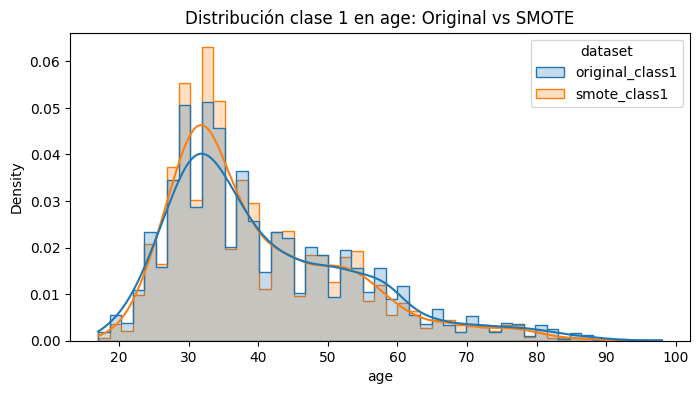

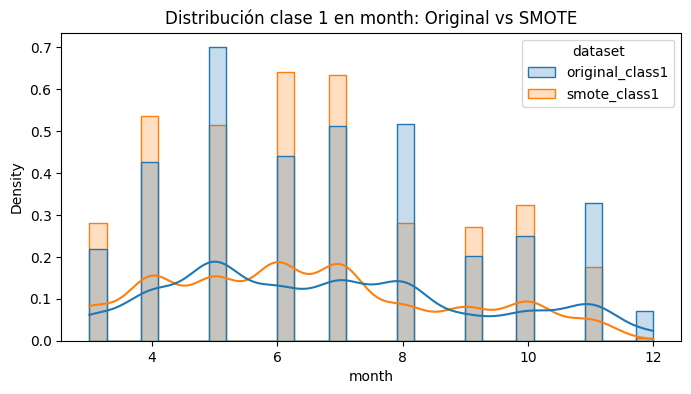

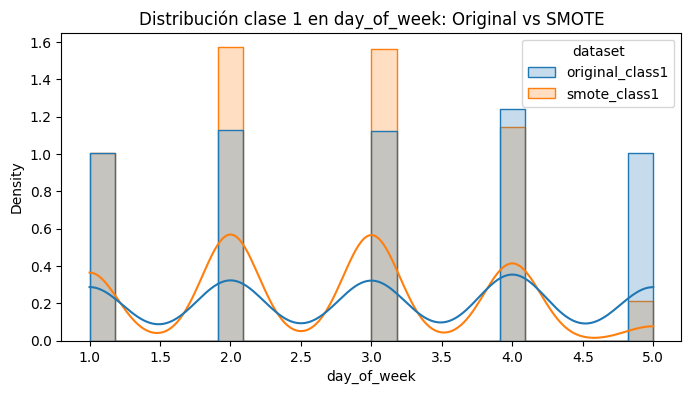

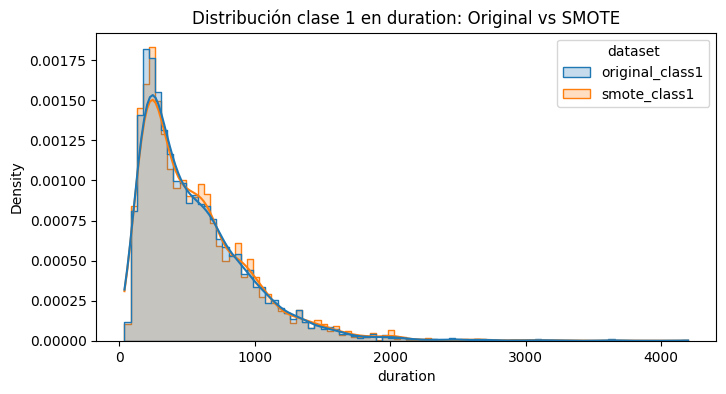

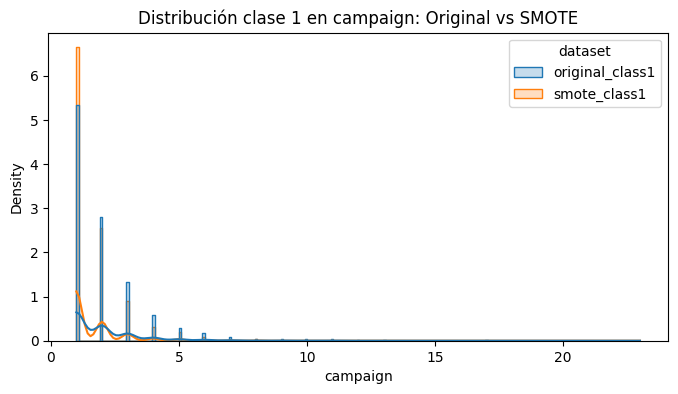

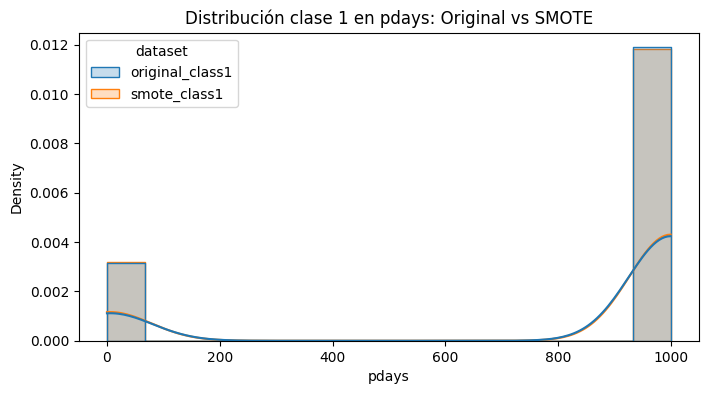

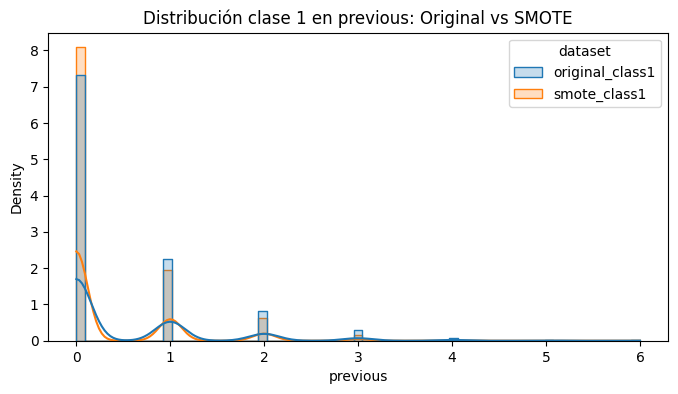

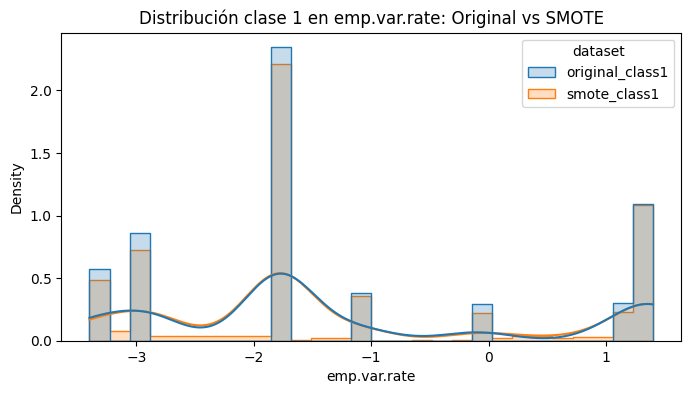

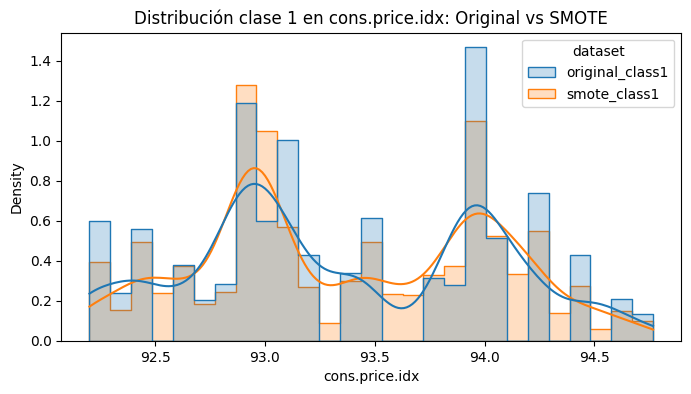

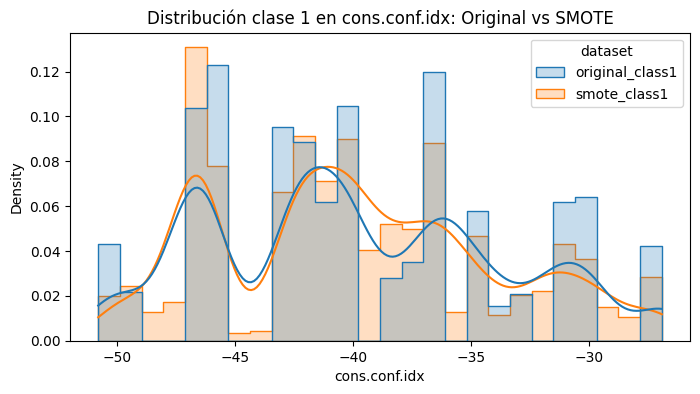

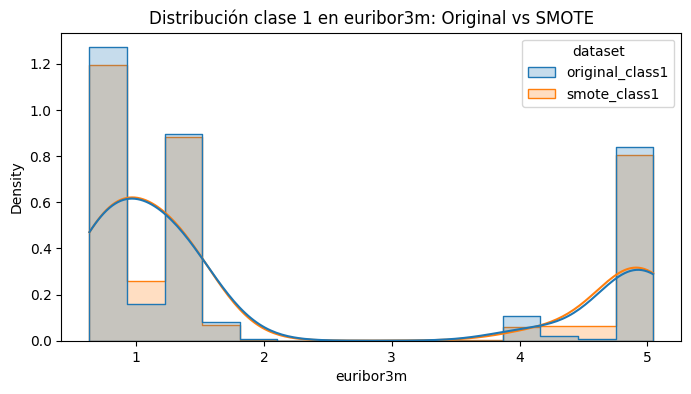

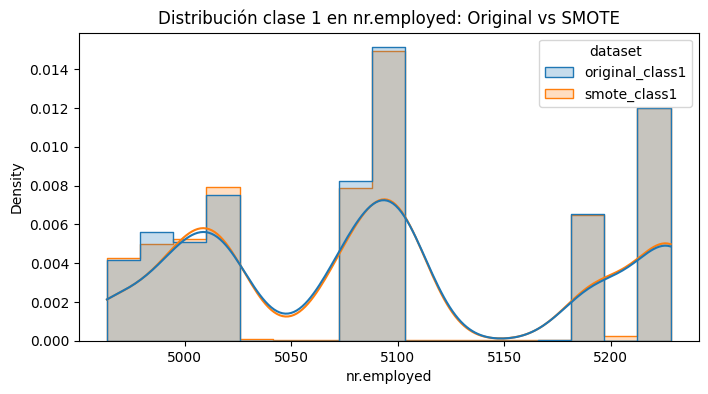

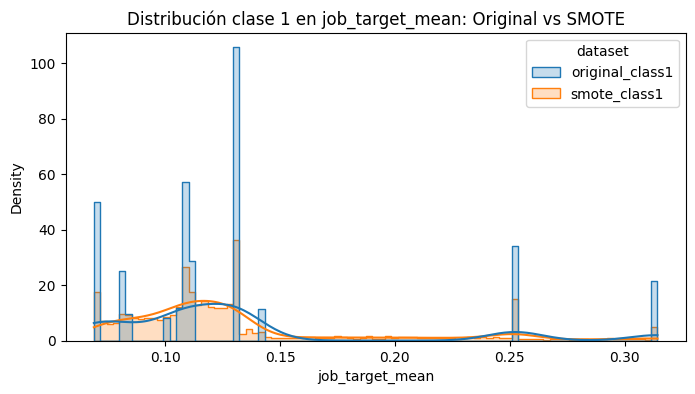

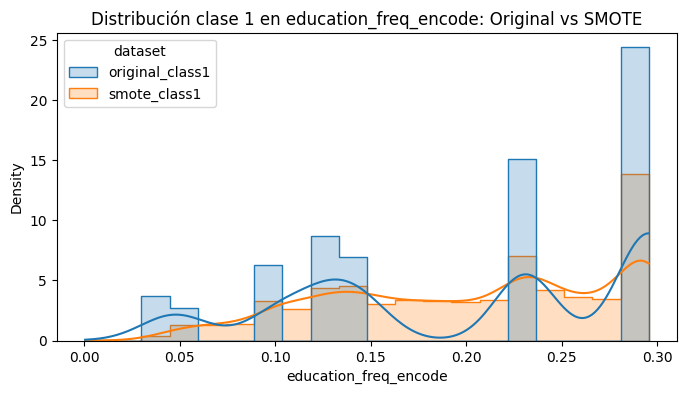

In [9]:
df_class1_orig = df[df['y'] == 1].copy()
df_class1_resampled = df_resampled[df_resampled['y'] == 1].copy()

df_class1_new = pd.concat([df_class1_resampled, df_class1_orig]).drop_duplicates(keep=False)

# Columna 'dataset' para diferenciar
df_class1_orig['dataset'] = 'original_class1'
df_class1_new['dataset'] = 'smote_class1'


df_compare_class1 = pd.concat([df_class1_orig, df_class1_new], axis=0)

print("Original (clase 1):", df_class1_orig.shape[0])
print("Sintéticos (clase 1, SMOTE):", df_class1_new.shape[0])

numeric_vars = ['age', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
                'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                'euribor3m', 'nr.employed', 'job_target_mean',
                'education_freq_encode']

for col in numeric_vars:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_compare_class1, x=col, hue='dataset', 
                 element="step", stat="density", common_norm=False, kde=True)
    plt.title(f"Distribución clase 1 en {col}: Original vs SMOTE")
    plt.show()

In [10]:
df_resampled = df_resampled.drop(columns=["dataset"])

KeyError: "['dataset'] not found in axis"

In [ ]:
output_path = "/workspaces/deteccion_clientes_banco/data/df_resampled.csv"
df_resampled.to_csv(output_path, index=False)

print(f"Archivo guardado en: {output_path}")


Archivo guardado en: /workspaces/deteccion_clientes_banco/models/df_resampled.csv
